In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import japanize_matplotlib

In [29]:
# CSVファイルを読み込む
file_path = "./logs/home/"

df_pressure = pd.read_csv(
    f"{file_path}Pressure.csv",
    header=0,
    names=("time", "pressure")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)

# 加速度から重力加速度を除去
df_acc["x"] = df_acc["x"] - df_acc["x"].mean()
df_acc["y"] = df_acc["y"] - df_acc["y"].mean()
df_acc["z"] = df_acc["z"] - df_acc["z"].mean()

# 加速度のノルムを計算する
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# 移動平均フィルターをかける
df_pressure['low'] = df_pressure['pressure'].rolling(window=240).mean()
df_pressure['mediafit'] = medfilt(df_pressure['pressure'], 241)


In [30]:
# 加速度から動いているかを判定する
def check_is_moving(part_acc):
    var = part_acc['norm'].var()
    if var >= 0.1:
        return (True, 'blue', 0.2)
    else:
        return (False, 'yellow', 0.2)


# 気圧から上下に動いているかを判定する
def check_is_updown(part_pressure):
    a, _ = np.polyfit(part_pressure['time'], part_pressure['low'], 1)

    if abs(a) > 0.012:
        return (True, 'blue', 0.2, abs(a))
    else:
        return (False, 'yellow', 0.2, abs(a))


In [31]:
# 加速度のグラフを描画する
def plot_acc(df, title, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  plt.ylabel('accelerometer\n[m/s^2]')
  plt.plot(df['time'], df['norm'])
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  for i in range(int(df['time'].max() + 1)):
    df_part = df.query(f'{i} <= time < {i+1}')

    is_moving, color, alpha = check_is_moving(df_part)

    plt.axvspan(i, i+1, color=color, alpha=alpha)

  plt.show()


In [32]:
# 気圧のグラフを描画する
def plot_pressure(df, title, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  plt.ylabel('pressure\n[hPa]')
  plt.plot(df['time'], df['pressure'], color='gray', alpha=0.5)
  plt.plot(df['time'], df['low'])
  plt.plot(df['time'], df['mediafit'], color='black')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  # data_a = []
  for i in range(int(df['time'].max() + 1)):
    part_pressure = df.query(f'{i-2} <= time < {i+2}')

    is_updown, color, alpha, a = check_is_updown(part_pressure)
    # data_a.append(a)

    plt.axvspan(i, i+1, color=color, alpha=alpha)

  plt.show()

  # fig = plt.figure(figsize=(10, 3))
  # plt.xlabel('time[s]')
  # plt.ylabel('a\n傾き')
  # plt.ylim(0, 0.2)
  # plt.xlim(0, len(data_a))
  # plt.plot(range(1, len(data_a)+1), data_a)


In [33]:
def correct_graph(data, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))

  plt.title('正解データ')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  s = 0
  for d in data:
    color, alpha = get_color_from_state(d['state'])
    plt.axvspan(s, d['time'], color=color, alpha=alpha)
    s = d['time']


In [34]:
def action_discrimination(df_acc, df_pressure, x):
  fig = plt.figure(figsize=(10, 3))

  plt.title('行動の判別')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  plt.ylim(0, 30)
  if x[0] < x[1]:
    plt.xlim(x[0], x[1])

  for i in range(int(df_acc['time'].max() + 1)):
    part_acc = df_acc.query(f'{i} <= time < {i+1}')
    part_pressure = df_pressure.query(f'{i-2} <= time < {i+2}')

    is_move = check_is_moving(part_acc)[0]
    is_updown = check_is_updown(part_pressure)[0]

    if is_updown and is_move:
      color, alpha = get_color_from_state('stairs')
    elif is_updown:
      color, alpha = get_color_from_state('elevator')
    elif is_move:
      color, alpha = get_color_from_state('walk')
    else:
      color, alpha = get_color_from_state('wait')

    plt.axvspan(i, i+1, color=color, alpha=alpha)

In [35]:
def get_color_from_state(state):
  if state == 'stairs':
    return ("red", 1)
  elif state == 'elevator':
    return ("blue", 1)
  elif state == 'walk':
    return ("yellow", 1)
  elif state == 'wait':
    return ("lightgreen", 1)

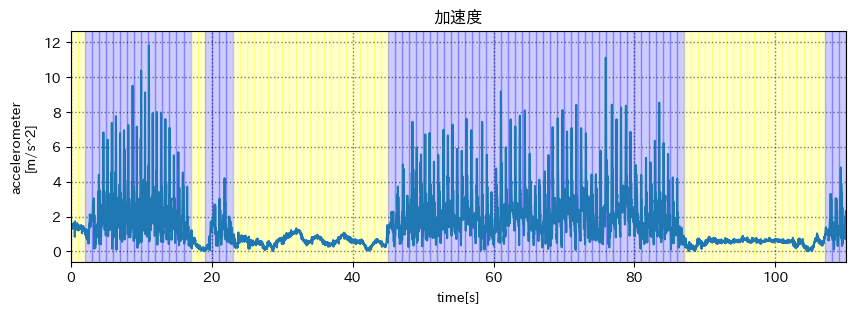

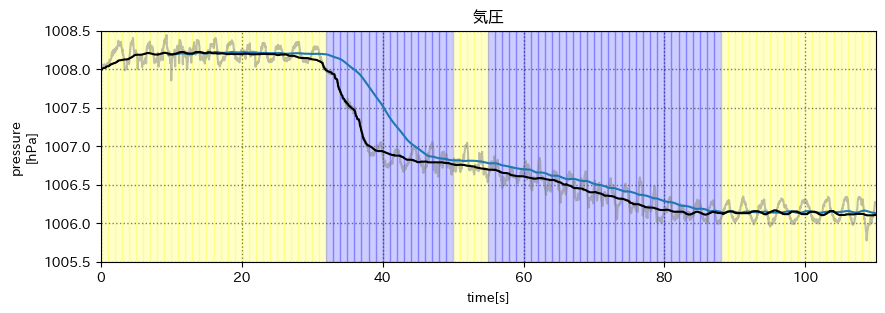

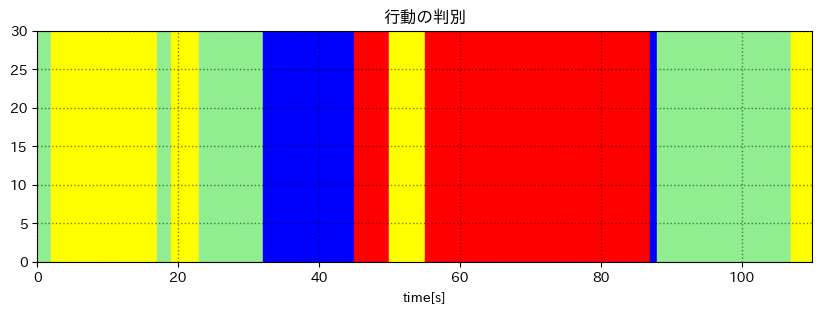

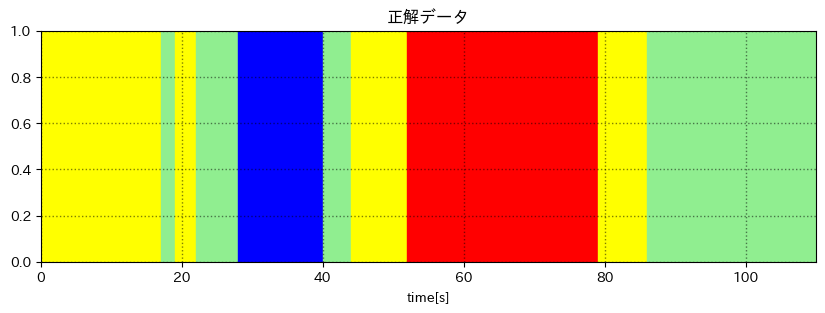

In [36]:
x = (0, 110)
correct_data = [
  {'time': 17, 'state': 'walk'},
  {'time': 19, 'state': 'wait'},
  {'time': 22, 'state': 'walk'},
  {'time': 28, 'state': 'wait'},
  {'time': 40, 'state': 'elevator'},
  {'time': 44, 'state': 'wait'},
  {'time': 52, 'state': 'walk'},
  {'time': 79, 'state': 'stairs'},
  {'time': 86, 'state': 'walk'},
  {'time': 105, 'state': 'wait'},
  {'time': 113, 'state': 'wait'},
  {'time': 130, 'state': 'elevator'},
  {'time': 152, 'state': 'walk'},
]

# 気圧
plot_acc(df_acc, '加速度', x, y=(0, 0))
# 加速度
plot_pressure(df_pressure, '気圧', x, (1005.5, 1008.5))
# 行動の判別
action_discrimination(df_acc, df_pressure, x)
# 正解データ
correct_graph(correct_data, x, (0, 0))


- 赤: 階段
- 青: エレベーター
- 黄: 歩行
- 緑: 待機
